# Twitter

In this notebook we are going to show all the used for the analysis. Also we are going to show all the graphics asociated with the data obtaines.


## Introduction

We downloaded data from twitter with various methods, which did not provide the same amount of data, so we standarized to the minimal amount which it could be useful. Those fields are: 
* Date when it was created at.
* ID of the tweet, which is unique.
* The text of the tweet.
* The user, which contains the user screen name (username) and the user ID.

After defining that the period of downloading data was finished, the amount of data gathered was: **6.542.718** unique tweets. Which is a decent amount of data to analyse.

## Analysis

1) The first step is to filter the data in different files that will be used for all the analysis. The filter will be keywords (in the meantime), the keywords are the platforms name (i.e. Nintendo, Playstation, Xbox), these keywords are searched in the text and the username. If there is no defined preference (not zero preference) in which platform the record was pointing to, it is inserted in both files.

The ideal method to filter the data would be create a database of keywords asociated with each platform, so in every record when searching it could be calculated the probability of that text (according to all the words) to which platform it goes. This would require a model with N-Bayes, but like most predictive models it requires training, which we do not have at this moment.

In [ ]:
import time
import json

if __name__ == '__main__':
    time_start = time.clock()
    nintendo_platform_file = []
    playstation_platform_file = []
    xbox_platform_file = []
    else_platform_file = []
    _file = open("project_tweets.data", 'r')
    for line in _file.readlines():
        data = json.loads(line)
        try:
            raw_text = data['text'].strip().upper()
            raw_username = data['user']['screen_name'].strip().upper()
        except:
            # No idea why would happen.
            print "WTF!"
            raw_text = ""
            raw_username = ""
        nintendo_mentions = raw_text.count("NINTENDO")
        playstation_mentions = raw_text.count("PLAYSTATION")
        xbox_mentions = raw_text.count("XBOX")
        nintendo_mentions += 1 if raw_username.find("NINTENDO") != -1 else 0
        playstation_mentions += 1 if raw_username.find("PLAYSTATION") != -1 else 0
        xbox_mentions += 1 if raw_username.find("XBOX") != -1 else 0
        if nintendo_mentions > playstation_mentions and nintendo_mentions > xbox_mentions:
            nintendo_platform_file.append(line)
        elif playstation_mentions > nintendo_mentions and playstation_mentions > xbox_mentions:
            playstation_platform_file.append(line)
        elif xbox_mentions > playstation_mentions and xbox_mentions > nintendo_mentions:
            xbox_platform_file.append(line)
        elif nintendo_mentions == playstation_mentions and nintendo_mentions == xbox_mentions and nintendo_mentions > 0:
            nintendo_platform_file.append(line)
            playstation_platform_file.append(line)
            xbox_platform_file.append(line)
        elif nintendo_mentions == playstation_mentions and nintendo_mentions != xbox_mentions:
            nintendo_platform_file.append(line)
            playstation_platform_file.append(line)
        elif nintendo_mentions == xbox_mentions and nintendo_mentions != playstation_mentions:
            nintendo_platform_file.append(line)
            xbox_platform_file.append(line)
        elif playstation_mentions == xbox_mentions and playstation_mentions != nintendo_mentions:
            playstation_platform_file.append(line)
            xbox_platform_file.append(line)
        else:
            else_platform_file.append(line)
    filenames = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for filename in filenames:
        # Clean files.
        open(filename, 'w').close()
        # Write files in append mode.
        with open(filename, 'a') as _file:
            if filename == "project_tweets01.data":
                for line in nintendo_platform_file:
                    _file.write(line)
            elif filename == "project_tweets02.data":
                for line in playstation_platform_file:
                    _file.write(line)
            elif filename == "project_tweets03.data":
                for line in xbox_platform_file:
                    _file.write(line)
            else:
                for line in else_platform_file:
                    _file.write(line)
    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


2) The first analysis to do with this data that is now filtered by platforms, is to count the amount of records per platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("records_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data", "project_tweets.data"]
    for _file in files:
        # Write to file in append mode.
        _fo = open("records_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        _data = open(_file, 'r')
        lines = _data.readlines()
        records = len(lines)
        print records, '\n'

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

* Nintendo: 1.317.667 
* Playstation: 2.337.881 
* Xbox: 2.260.157 
* Else: 735.410 

* Total tweets (with no filtering): 6.542.718 

Time taken to completion of the metric: 37.615491 in processor time

**Analysis**

From this we can see that in the "Else" category we have **11.24%** of all the data, which is not a small amount. But considering that our filter for the platforms is kind of brute force is all right.

3) The next analysis to do is to count the amount of unique users per platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("user_amount_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['user_amount.py', option1, option2, _file]
        # Write to file in append mode.
        _fo = open("user_amount_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('user_amount.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        yield [record['user']['screen_name'], 1]

    def reducer(self, key, values):
        yield [key, 1]

    def mapper2(self, key, values):
        yield ['amount_users', values]

    def reducer2(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer),
                MRStep(mapper=self.mapper2, reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**


| Platform Name | Amount of Users |
|---------------|-----------------|
| Nintendo      | 426.450         |
| Playstation   | 574.308         |
| Xbox          | 727.273         |
| Else          | 265.827         |

Time taken to completion of the metric: 426.030981 in processor time


**Analysis**

From this we can see that in the Xbox platform there are more unique users than in all the other platforms by a not small percentage, it almost duplicates Nintendo unique users. What is interesting, is using the analysis from before we can see that Xbox had less records than Playstation, but seeing this there is a whooping 150k (estimated) more unique users in Xbox, which could lead us that Playstation content creation is more for each unique user or that there is a tiny amount of users that produce all the content for this platform.

4) The next analysis is to calculate the Top 10 users that generate the most content in each platform. This is done with the next script.

In [ ]:
import time
import sys

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("top_users_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['top_users.py', option1, option2, _file]
        # Write to file in append mode.
        _fo = open("top_users_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('top_users.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import operator
import sys

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        yield [record['user']['screen_name'], 1]

    def reducer(self, key, values):
        yield ["top_user", (sum(values), key)]

    def reducer2(self, key, values):
        user_ids = []
        user_tweets = []
        for value in values:
            user_ids.append(value[1])
            user_tweets.append(value[0])
        user = {}
        for i in xrange(0, len(user_ids)):
            user[user_ids[i]] = user_tweets[i]
        top_users = sorted(user.items(), key=lambda x: (x[1], operator.itemgetter(0)), reverse=True)
        for user in top_users[0:10]:
            #print user[0], user[1]
            yield [user[0], user[1]]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer),
                MRStep(reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

###### Nintendo

| Username | Amount of Tweets |
|----------|------------------|
| savetimeandmoey| 11.391|
| AuctionPorn| 8.449|
| AmazonBay4u| 8.352|
| retrodeals| 7.435|
| Nintendo_Legend| 6.895|
| retrodealsUK| 6.744|
| LastChanceGamer| 5.904|
| GameUP247| 5.580|
| RetroNuss| 5.441|
| Nintendoe3E3| 5.438|

###### Playstation

| Username | Amount of Tweets |
|----------|------------------|
| Cammie_Whybrew| 13.616|
| AskPlayStation| 13.282|
| eBayShopperNews| 11.578|
| VideoGamesMall| 10.274|
| savetimeandmoey| 8.632|
| collinschristof| 5.382|
| topnewskoeln| 5.297|
| Gamifive| 4.829|
| Xbox_360_Gamez| 4.080|
| pressebank| 3.799|

###### Xbox

| Username | Amount of Tweets |
|----------|------------------|
| Xbox_360_Gamez| 34.137|
| XboxSupport| 14.421|
| VideoGamesMall| 11.835|
| Xbox_One_Reddit| 10.215|
| xboxgamersdeals| 9.224|
| GameUP247| 9.156|
| KingsleyNewz| 9.139|
| bullzyy| 7.576|
| savetimeandmoey| 7.176|
| giveawayxfab| 7.028|

###### Else

| Username | Amount of Tweets |
|----------|------------------|
| savetimeandmoey| 15.483|
| VideoGames_Up| 13.804|
| giveawaygigatop| 8.878|
| tw100_1| 6.538|
| videogames_pt| 6.357|
| videogames_fr| 5.993|
| giveawayxfab| 5.886|
| DMGG_Videogames| 5.295|
| ShoppeWorld| 4.824|
| VideoGames_TV| 3.709|


Time taken to completion of the metric: 335.930534 in processor time


**Analysis**

From this we can see that there are some users in more than one platform, and that they are one of the top 10 users that generate contents, which means that they are probably spammers, bots or someone really good at making records for almost all the platforms.

5) The nexts analysis of the data is by each hour of a day in every week (the data was gathered).

5.1) We now calculate the Top 20 words. That is how many times a single word was used in each record for each platform. This is done with the next script.

In [ ]:
import time
import sys
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import json
from datetime import datetime
from dateutil.parser import parse
import operator

# The summary is for each hour per week. (i.e. 20 times hello on week 1, 31 times bye on week 2, ...)

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("count_words_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        punctuation = []
        open(_file[:-5] + "_words.data", 'w').close()
        _output = open(_file[:-5] + "_words.data", 'a')
        _output_filename = _output.name
        for i in xrange(0, len(string.punctuation)):
            punctuation.append(string.punctuation[i])
        stop_words = stopwords.words() + punctuation
        _data = open(_file, 'r')
        for line in _data.readlines():
            data = json.loads(line)
            date = parse(data['created_at'])
            week = date.isocalendar()[1]
            hour = date.hour
            _words = [i for i in word_tokenize(data['text'].lower()) if i not in stop_words]
            for word in _words:
                record = {'word': word, 'week': week, 'hour': hour}
                _output.write(json.dumps(record, sort_keys=True) + "\n")
        _data.close()
        _output.close()
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['words_amount.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("count_words_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('words_amount.py')
        print "\n"

    time_end = time.clock()
    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys
from datetime import datetime
from dateutil.parser import parse
import operator

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        hour = record['hour']
        week = record['week']
        word = record['word']
        yield [(week, hour, word), 1]

    def reducer(self, key, values):
        yield [(key[0], key[1]), (sum(values), key[2])]

    def reducer2(self, key, values):
        counts = []
        words = []
        for value in values:
            words.append(value[1])
            counts.append(value[0])
        pair_word_count = {}
        for i in xrange(0, len(words)):
            pair_word_count[words[i]] = counts[i]
        top_words = sorted(pair_word_count.items(), key=lambda x: (x[1], operator.itemgetter(0)), reverse=True)
        for word in top_words[0:20]:
            #print user[0], user[1]
            yield [(key[0], key[1], word[0]), word[1]]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer), MRStep(reducer=self.reducer2)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Results**

**Note:** Partial Results, because they were large files of output. 

###### Nintendo

| Week | Hour | Word | Times Used |
|----------|--|-|-|
|...|...|...|...|
|26| 0| "nintendo"|	1429 |
|26| 0| "//"|	801|
|26| 0| "http"|	764|
|26| 0| "\u2026"|	321|
|26| 0| "https"|	225|
|26| 0| "//www"|	185|
|26| 0| "..."|	149|
|26| 0| "t-shirt"|	138|
|26| 0| "games"|	135|
|26| 0| "3ds"|	135|
|26| 0| "design"|	131|
|26| 0| "contest"|	130|
|26| 0| "new"|	122|
|26| 0| "miyamoto"|	121|
|26| 0| "youtube"|	120|
|26| 0| "shigeru"|	119|
|26| 0| "judged"|	116|
|26| 0| "wii"|	112|
|26| 0| "'s"|	107|
|26| 0| "video"|	106|
|26| 1| "nintendo"|	1281|
|26| 1| "//"|	704|
|26| 1| "http"|	691|
|26| 1| "\u2026"|	320|
|26| 1| "https"|	203|
|26| 1| "//www"|	190|
|26| 1| "wii"|	122|
|26| 1| "..."|	119|
|26| 1| "super"|	116|
|26| 1| "3ds"|	112|
|26| 1| "game"|	108|
|26| 1| "youtube"|	105|
|26| 1| "games"|	104|
|26| 1| "'s"|	103|
|26| 1| "nx"|	102|
|26| 1| "video"|	98|
|26| 1| "new"|	95|
|26| 1| "mario"|	89|
|26| 1| "ebay"|	78|
|26| 1| "console"|	70|
|...|...|...|...|

Time taken to completion of the metric: 11715.7655995 in processor time




**Analysis**

From this we can see which hours in which week. The Top 20 most used words in all of that period records by platform.



5.2) We now calculate how many records have a sentiment of "positiveness", "negativeness" or "neutralness" for each platform with the next script.

In [ ]:
import time
import sys
import sentiment_analyzer as sa

# The summary is for each hour per week. (i.e. 20 positives tweets on week 1, 31 negative tweets on week 2, ...)

if __name__ == '__main__':
    time_start = time.clock()
    sid = sa.init_classifier()
    # Clean File.
    open("sentiment_analysis_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        _output_filename = sa.classify_file(_file, sid)
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['sentiment_amount.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("sentiment_analysis_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('sentiment_amount.py')
        print "\n"

    time_end = time.clock()

    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import sys


def init_classifier():
    n_instances = 100
    subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
    obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

    train_subj_docs = subj_docs[:80]
    test_subj_docs = subj_docs[80:100]
    train_obj_docs = obj_docs[:80]
    test_obj_docs = obj_docs[80:100]
    training_docs = train_subj_docs + train_obj_docs
    testing_docs = test_subj_docs + test_obj_docs

    sentim_analyzer = SentimentAnalyzer()
    all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])
    unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
    sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
    training_set = sentim_analyzer.apply_features(training_docs)
    test_set = sentim_analyzer.apply_features(testing_docs)
    trainer = NaiveBayesClassifier.train
    classifier = sentim_analyzer.train(trainer, training_set)
    sid = SentimentIntensityAnalyzer()
    return sid


def classify_file(_file, sid):
    _data = open(_file, 'r')
    open(_file[:-5] + "_classified.data", 'w').close()
    _output = open(_file[:-5] + "_classified.data", 'a')
    for line in _data.readlines():
        record = json.loads(line)
        ss = sid.polarity_scores(record['text'].encode('utf-8'))
        if ss['compound'] < 0:
            classification = "neg"
        elif ss['compound'] == 0:
            classification = "neu"
        else:
            classification = "pos"
        try:
            record.update({'classification': classification})
            _output.write(json.dumps(record, sort_keys=True) + "\n")
        except:
            # Should not happen.
            print "WTF!"
    _data.close()
    _output.close()
    return _output.name

if __name__ == '__main__':
    pass


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import time
import itertools
import sys
from datetime import datetime
from dateutil.parser import parse

class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        date = parse(record['created_at'])
        week = date.isocalendar()[1]
        hour = date.hour
        yield [(week, hour, record['classification']), 1]

    def reducer(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer)]


if __name__ == '__main__':
    #time_start = time.clock()
    MRWordFrequencyCount().run()
    #time_end = time.clock()
    #print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


**Confidence/Accuracy**

But, first we have to know the "confidence" or the accuracy of our model to predict the sentiment of the tweets. To do this we pre-classify 100 tweets with the sentiment we could sense in it, of course this is also subjective but is the only way to see somekind of accuracy.
To do this we made a file with the 100 tweets pre-classified and used the script above to identify the sentiment of it according to the model, which will make another file with both classifications, to be easy to compare by the next script. 

In [1]:
import sentiment_analyzer as sa
import json

# The preclassified files only have 100 registers, because we did not have more time to pre-classificate
sentiment_file = "preclassified_sentiment.data"

classifier = sa.init_classifier()
_output2 = sa.classify_file(sentiment_file, classifier)

# Check correct predictions of: sentiment
count_errors = 0
count_tweets = 0
with open(_output2, 'r') as fo:
    for line in fo.readlines():
        if len(line) != 0:
            values = json.loads(line)
            if values['classification'] != values['real_classification']:
                count_errors += 1
            count_tweets += 1
print "The percentage of correct predictions for sentiments is: {}%".format(float(count_tweets - count_errors) / count_tweets * 100)

Training classifier
The percentage of correct predictions for sentiments is: 89.0%


d:\users\benja\documents\icc1012_proyecto\myenv\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


**Results**

**Note:** Partial Results, because they were large files of output. 

###### Nintendo

| Week | Hour | Sentiment | Quantity |
|----------|--|-|-|
|...|...|...|...|
|14| 22| "neu"|	1|
|25| 17| "neg"|	1|
|26| 0| "neg"|	149|
|26| 0| "neu"|	827|
|26| 0| "pos"|	485|
|26| 1| "neg"|	153|
|26| 1| "neu"|	721|
|26| 1| "pos"|	439|
|...|...|...|...|


Time taken to completion of the metric: 1356.91702487 in processor time


**Analysis**

From this we can see which hours in which week had more positive or negative records by platform.

The peaks for Nintendo are. Week 35 we can the first peak is related to the Nintendo 3DS Direct. Week 42 we can see another peak that is related with the annoucement of Nintendo Switch.
The peaks for Playstation are. Week 36 we can see the peak because there was a conference for the new PlayStation 4 PRO. Week 41 we can see that the amount of negative comments increased with the release of the PlayStation VR and later that same day the comments were more neutral about it. 
The peaks for Xbox are. Week 39 data flow increases maybe of the new Xbox One S. We can see that at the very end of the weeks the data flow increases, this could be because of the Xbox One S or the new Xbox Scorpio.


**Graphics**

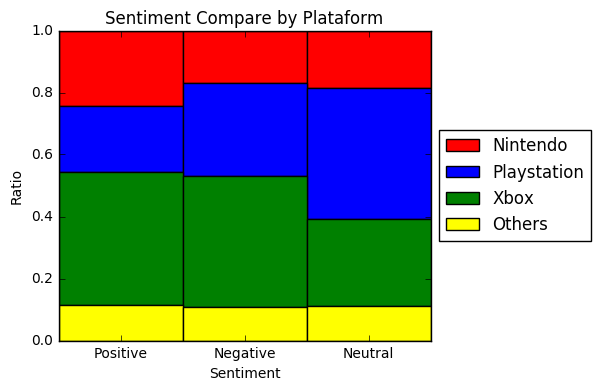

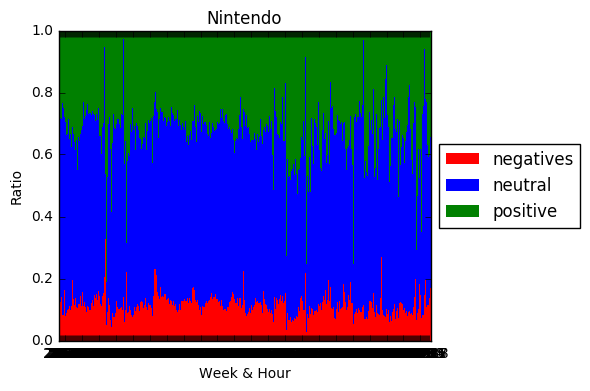

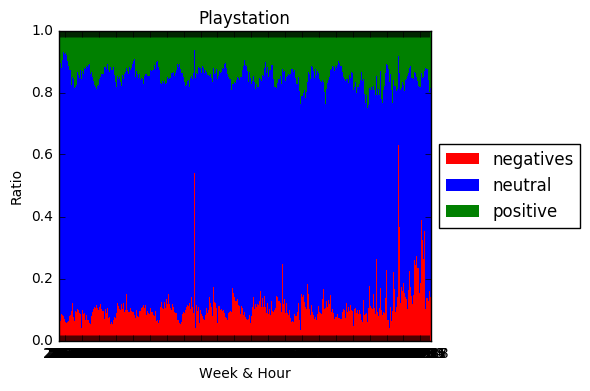

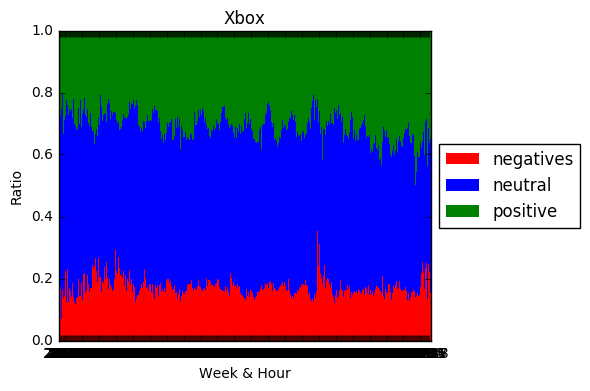

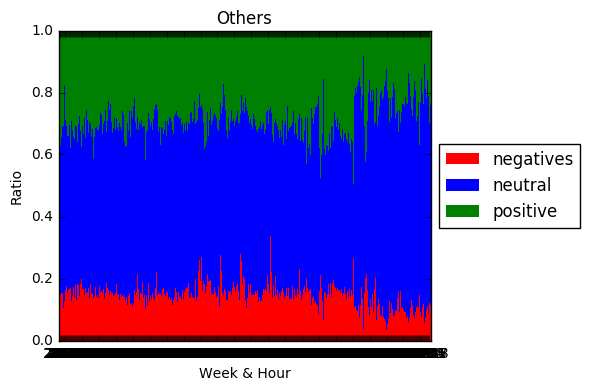

In [3]:
import matplotlib.pyplot as plt
import numpy as np

archivo = open("sentiment_analysis_by_platform_summary.txt")

########################################
###############Nintendo#################
########################################

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
neg.pop()
neu.pop()
n= len(neg)
neg = sorted(neg)
neu = sorted(neu)
pos = sorted(pos)
for i in xrange(n):
	suma = float(neg[i][2]+neu[i][2]+pos[i][2])
	neu[i][2] = neu[i][2]/suma
	pos[i][2] = pos[i][2]/suma
	neg[i][2] = neg[i][2]/suma
width= 1
ind=np.arange(n)

x_neg_name = []
y_neg = []

ax = plt.subplot(111)
for i in sorted(neg):
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])

plt.xticks(ind + width/2, x_neg_name)
neg_plt = plt.bar(0.6 + ind, y_neg,width, color="red",label='negatives', edgecolor = "none")

x_neu_name = []
y_neu = []

for i in sorted(neu):
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])

plt.xticks(ind + width/2, x_neu_name)
neu_plt = plt.bar(0.6 + ind, y_neu, width,color="blue",label='neutral',bottom=y_neg, edgecolor = "none")



x_pos_name = []
y_pos = []

for i in sorted(pos):
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])


plt.xticks(ind + width/2, x_pos_name)
pos_plt = plt.bar(0.6 + ind, y_pos, width,color="green", label='positive', bottom=np.array(y_neu)+np.array(y_neg), edgecolor = "none")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Nintendo")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
plt.show()

########################################
#############Playstation################
########################################

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
neg.pop()
n= len(neg)
neg = sorted(neg)
neu = sorted(neu)
pos = sorted(pos)

for i in xrange(n):
	suma = float(neg[i][2]+neu[i][2]+pos[i][2])
	neu[i][2] = neu[i][2]/suma
	pos[i][2] = pos[i][2]/suma
	neg[i][2] = neg[i][2]/suma

width= 1
ind=np.arange(n)

x_neg_name = []
y_neg = []

ax = plt.subplot(111)
for i in sorted(neg):
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])
	
plt.xticks(ind + width/2, x_neg_name)
neg_plt = plt.bar(0.6 + ind, y_neg,width, color="red",label='negatives', edgecolor = "none")

x_neu_name = []
y_neu = []

for i in sorted(neu):
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	
plt.xticks(ind + width/2, x_neu_name)
neu_plt = plt.bar(0.6 + ind, y_neu, width,color="blue",label='neutral',bottom=y_neg, edgecolor = "none")

x_pos_name = []
y_pos = []

for i in sorted(pos):
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])

plt.xticks(ind + width/2, x_pos_name)
pos_plt = plt.bar(0.6 + ind, y_pos, width,color="green", label='positive', bottom=np.array(y_neu)+np.array(y_neg), edgecolor = "none")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Playstation")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
plt.show()

########################################
#################Xbox###################
########################################

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
n= len(neg)
neg = sorted(neg)
neu = sorted(neu)
pos = sorted(pos)

for i in xrange(n):
	suma = float(neg[i][2]+neu[i][2]+pos[i][2])
	neu[i][2] = neu[i][2]/suma
	pos[i][2] = pos[i][2]/suma
	neg[i][2] = neg[i][2]/suma

width= 1
ind=np.arange(n)

x_neg_name = []
y_neg = []

ax = plt.subplot(111)
for i in sorted(neg):
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])

plt.xticks(ind + width/2, x_neg_name)
neg_plt = plt.bar(0.6 + ind, y_neg,width, color="red",label='negatives', edgecolor = "none")

x_neu_name = []
y_neu = []

for i in sorted(neu):
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])
	
plt.xticks(ind + width/2, x_neu_name)
neu_plt = plt.bar(0.6 + ind, y_neu, width,color="blue",label='neutral',bottom=y_neg, edgecolor = "none")

x_pos_name = []
y_pos = []

for i in sorted(pos):
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])
	

plt.xticks(ind + width/2, x_pos_name)
pos_plt = plt.bar(0.6 + ind, y_pos, width,color="green", label='positive', bottom=np.array(y_neu)+np.array(y_neg), edgecolor = "none")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Xbox")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
plt.show()

########################################
#################Others#################
########################################

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos.append([int(line[0]), int(line[1]), int(line[3])])
	elif line[2] == "neg":
		neg.append([int(line[0]), int(line[1]), int(line[3])])
	else:
		neu.append([int(line[0]), int(line[1]), int(line[3])])
neu.pop()
n= len(neu)
neg = sorted(neg)
neu = sorted(neu)
pos = sorted(pos)

for i in xrange(n):
	suma = float(neg[i][2]+neu[i][2]+pos[i][2])
	neu[i][2] = neu[i][2]/suma
	pos[i][2] = pos[i][2]/suma
	neg[i][2] = neg[i][2]/suma

width= 1
ind=np.arange(n)

x_neg_name = []
y_neg = []

ax = plt.subplot(111)
for i in sorted(neg):
	x_neg_name.append(str(i[0])+ " " + str(i[1]))
	y_neg.append(i[2])

plt.xticks(ind + width/2, x_neg_name)
neg_plt = plt.bar(0.6 + ind, y_neg,width, color="red",label='negatives', edgecolor = "none")


x_neu_name = []
y_neu = []

for i in sorted(neu):
	x_neu_name.append(str(i[0])+ " " + str(i[1]))
	y_neu.append(i[2])

plt.xticks(ind + width/2, x_neu_name)
neu_plt = plt.bar(0.6 + ind, y_neu, width,color="blue",label='neutral',bottom=y_neg, edgecolor = "none")

x_pos_name = []
y_pos = []

for i in sorted(pos):
	x_pos_name.append(str(i[0])+ " " + str(i[1]))
	y_pos.append(i[2])

plt.xticks(ind + width/2, x_pos_name)
pos_plt = plt.bar(0.6 + ind, y_pos, width,color="green", label='positive', bottom=np.array(y_neu)+np.array(y_neg), edgecolor = "none")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Others")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
plt.show()


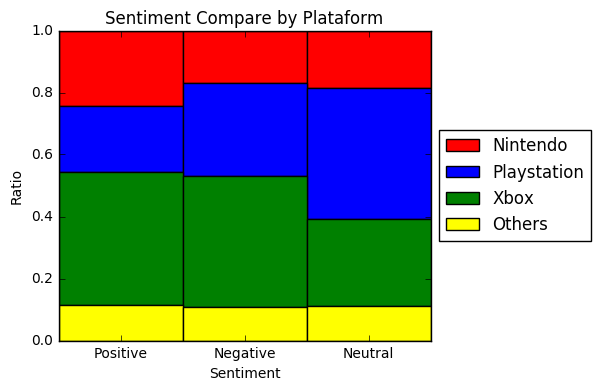

In [4]:
import matplotlib.pyplot as plt
import numpy as np

archivo = open("sentiment_analysis_by_platform_summary.txt")
archivo.readline()
archivo.readline()
pos_nintendo = 0
neg_nintendo = 0
neu_nintendo = 0
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos_nintendo += int(line[3])
	elif line[2] == "neg":
		neg_nintendo += int(line[3])
	else:
		neu_nintendo += int(line[3])

########################################
#############Playstation################
########################################

archivo.readline()
archivo.readline()
pos_playstation = 0
neg_playstation = 0
neu_playstation = 0
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos_playstation += int(line[3])
	elif line[2] == "neg":
		neg_playstation += int(line[3])
	else:
		neu_playstation += int(line[3])

########################################
#################Xbox###################
########################################

archivo.readline()
archivo.readline()
pos_xbox = 0
neg_xbox = 0
neu_xbox = 0
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos_xbox += int(line[3])
	elif line[2] == "neg":
		neg_xbox += int(line[3])
	else:
		neu_xbox += int(line[3])

########################################
#################Others#################
########################################

archivo.readline()
archivo.readline()
pos_others = 0
neg_others = 0
neu_others = 0
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] == "pos":
		pos_others += int(line[3])
	elif line[2] == "neg":
		neg_others += int(line[3])
	else:
		neu_others += int(line[3])


total_pos = float(pos_nintendo + pos_xbox + pos_playstation + pos_others)
total_neg = float(neg_others + neg_xbox + neg_playstation + neg_nintendo)
total_neu = float(neu_others + neu_xbox + neu_playstation + neu_nintendo)

nintendo_plot = [float(pos_nintendo/total_pos), float(neg_nintendo/total_neg), float(neu_nintendo/total_neu)]
playstation_plot = [float(pos_playstation/total_pos), float(neg_playstation/total_neg), float(neu_playstation/total_neu)]
xbox_plot = [float(pos_xbox/total_pos), float(neg_xbox/total_neg), float(neu_xbox/total_neu)]
others_plot = [float(pos_others/total_pos), float(neg_others/total_neg), float(neu_others/total_neu)]
ind=np.arange(3)
width= 1
x_valus=['Positive', 'Negative', 'Neutral']
ax = plt.subplot(111)
bottom=[1]*3
plt.xticks(ind + 0.5, x_valus)
bottom -= np.array(nintendo_plot)
plt.bar(ind , nintendo_plot, width,label='Nintendo', color='red', bottom=bottom)
bottom -= np.array(playstation_plot)
plt.bar(ind, playstation_plot, width,label='Playstation', bottom=bottom)
bottom -= np.array(xbox_plot)
plt.bar(ind, xbox_plot, width,label='Xbox', bottom=bottom, color='green')
bottom -= np.array(others_plot)
plt.bar(ind, others_plot, width,label='Others', bottom=bottom, color='yellow')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Sentiment Compare by Plataform")
plt.xlabel('Sentiment')
plt.ylabel('Ratio')
plt.axis([0, 3, 0, 1])
plt.show()

5.3) We now calculate how many records are from the different languages for each platform with the next script.

In [ ]:
import time
import sys
import language_detect as ld

# The summary is for each hour per week. (i.e. 20 spanish tweets on week 1, 31 english tweets on week 2, ...)

# Important Note: This is just an estimation of the language based on the stopwords, so if no stopwords are found the language
#                   that will produce is garbage, but is not the fault of the model. Also if there are some stopwords of both
#                   languages it will say is the one with most stopwords.

if __name__ == '__main__':
    time_start = time.clock()
    # Clean File.
    open("languages_amount_by_platform_summary.txt", 'w').close()
    files = ["project_tweets01.data", "project_tweets02.data", "project_tweets03.data", "project_tweets04.data"]
    for _file in files:
        _output_filename = ld.set_language_for_each_tweet(_file)
        # parameters for mrjob.
        # To run your job in multiple subprocesses with a few Hadoop features simulated, use -r local.
        option1 = "" #""-r"
        option2 = "" #""local"
        sys.argv = ['count_language.py', option1, option2, _output_filename]
        # Write to file in append mode.
        _fo = open("languages_amount_by_platform_summary.txt", 'a')
        sys.stdout = _fo
        print _file
        execfile('count_language.py')
        print "\n"

    time_end = time.clock()
    print "Time taken to completion of the metric: {0} in processor time".format(time_end - time_start)


In [ ]:
import sys
import json
reload(sys)
sys.setdefaultencoding('utf8')
try:
    from nltk import wordpunct_tokenize
    from nltk.corpus import stopwords
except ImportError:
    print '[!] You need to install nltk (http://nltk.org/index.html)'



#----------------------------------------------------------------------
def _calculate_languages_ratios(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Dictionary with languages and unique stopwords seen in analyzed text
    @rtype: dict
    """

    languages_ratios = {}

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
    >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios


#----------------------------------------------------------------------
def detect_language(text):
    """
    Calculate probability of given text to be written in several languages and
    return the highest scored.
    
    It uses a stopwords based approach, counting how many unique stopwords
    are seen in analyzed text.
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Most scored language guessed
    @rtype: str
    """

    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language


def set_language_for_each_tweet(_file):
    _data = open(_file, 'r')
    open(_file[:-5] + "_language.data", 'w').close()
    _output = open(_file[:-5] + "_language.data", 'a')
    for line in _data.readlines():
        record = json.loads(line)
        language = detect_language(record['text'].encode('utf-8'))
        try:
            record.update({'language': language})
            _output.write(json.dumps(record, sort_keys=True) + "\n")
        except:
            # Should not happen.
            print "WTF!"
    _data.close()
    _output.close()
    return _output.name



In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
from datetime import datetime
import itertools
from datetime import datetime
from dateutil.parser import parse


class MRWordFrequencyCount(MRJob):
    INPUT_PROTOCOL = JSONValueProtocol

    def mapper(self, _, record):
        date = parse(record['created_at'])
        week = date.isocalendar()[1]
        hour = date.hour
        yield [(week, hour, record['language']), 1]

    def reducer(self, key, values):
        yield [key, sum(values)]

    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer)]

if __name__ == '__main__':
    MRWordFrequencyCount.run()


**Confidence/Accuracy**

But, first we have to know the "confidence" or the accuracy of our model to predict the language of the tweets. To do this we pre-classify 100 tweets with the language we could determine in it, but there are tweets that do not show any particular languages an example would be a tweet of just a link or url. There are also tweets that only use about 2-3 words of a particular language but no stopwords (which makes the model to fail, giving a language result that is garbage most of the times).
To do this we made a file with the 100 tweets pre-classified and used the script above to identify the language in it, then pass it to the prediction language model, which will make another file with both classifications of languages, to be easy to compare by the next script.

In [5]:
import language_detect as ld
import json

# The preclassified files only have 100 registers, because we did not have more time to pre-classificate
language_file = "preclassified_language.data"

_output = ld.set_language_for_each_tweet(language_file)

# Check correct predictions of: languages
count_errors = 0
count_tweets = 0
with open(_output, 'r') as fo:
    for line in fo.readlines():
        if len(line) != 0:
            values = json.loads(line)
            if values['language'] != values['real_language']:
                count_errors += 1
            count_tweets += 1
print "The percentage of correct predictions for languages is: {}%".format(float(count_tweets - count_errors) / count_tweets * 100)

The percentage of correct predictions for languages is: 77.0%

**Results**

**Note:** Partial Results, because they were large files of output. 

###### Nintendo

| Week | Hour | Language | Quantity |
|----------|--|-|-|
|...|...|...|...|
|14| 22| "english"|	1|
|25| 17| "english"|	1|
|26| 0| "danish"|	7|
|26| 0| "dutch"|	34|
|26| 0| "english"|	792|
|26| 0| "finnish"|	22|
|26| 0| "french"|	34|
|26| 0| "german"|	9|
|26| 0| "hungarian"|	63|
|26| 0| "italian"|	2|
|26| 0| "portuguese"|	254|
|26| 0| "spanish"|	92|
|26| 0| "swedish"|	152|
|...|...|...|...|


**Analysis**

From this we can see which hours in which week had more records made in the different languages by platform.


** Graphics **

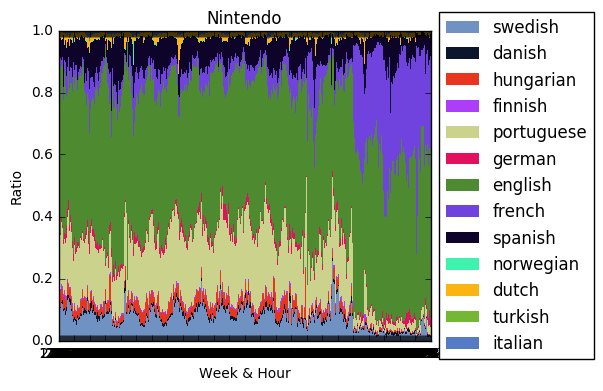

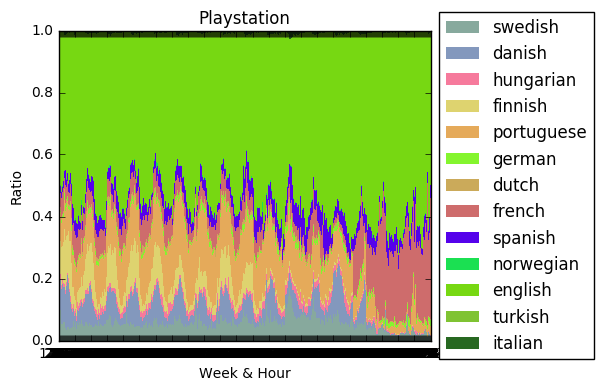

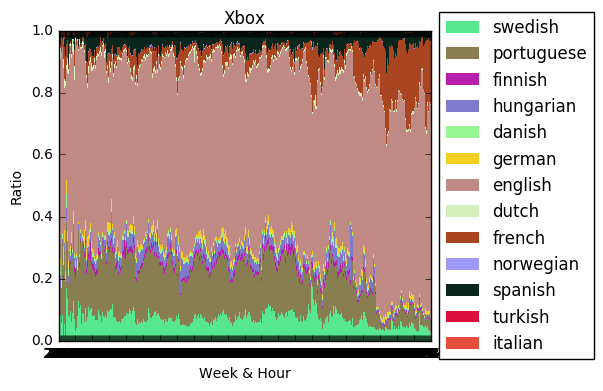

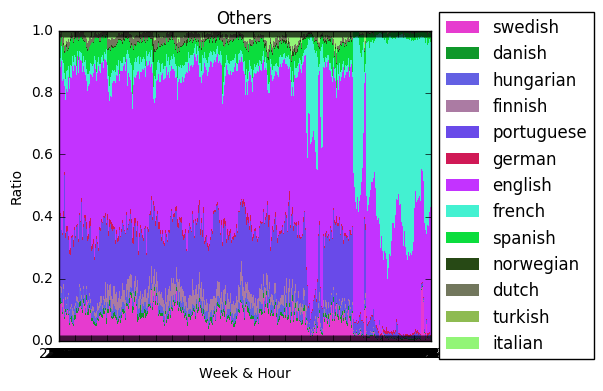

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

archivo = open("languages_amount_by_platform_summary.txt")

########################################
###############Nintendo#################
########################################

archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
fechas = set()
suma_fechas = {}
width= 1
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([(int(line[0]), int(line[1])), int(line[3])])
	try:
		suma_fechas[(int(line[0]), int(line[1]))] += int(line[3])
	except:
		suma_fechas[(int(line[0]), int(line[1]))] = int(line[3])
	fechas.add((int(line[0]), int(line[1])))
fechas = sorted(fechas)
bottom = [0]*len(fechas)
ax = plt.subplot(111)
for i in languages.keys():
	color=(random.random(),random.random(),random.random())
	x = []
	x_name = []
	y = []
	count = 0
	inicio_len = 0
	leng = sorted(languages[i])
	n =len(leng)
	for j in xrange(len(fechas)):
		x.append(count)
		x_name.append(str(fechas[j][0])+ " " + str(fechas[j][1]))
		if inicio_len < n:
			if leng[inicio_len][0] == fechas[j]:
				y.append(leng[inicio_len][1]/float(suma_fechas[fechas[j]]))
				inicio_len += 1
				count += 1
			else:
				y.append(0)
				count += 1
		else:
			y.append(0)
			count += 1
	plt.xticks(x, x_name)
	plt.bar(x, y,width,label=i,bottom=bottom, edgecolor = "none", color=color)
	bottom += np.array(y)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Nintendo")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.show()

########################################
#############Playstation################
########################################

archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
fechas = set()
suma_fechas = {}
width= 1
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([(int(line[0]), int(line[1])), int(line[3])])
	try:
		suma_fechas[(int(line[0]), int(line[1]))] += int(line[3])
	except:
		suma_fechas[(int(line[0]), int(line[1]))] = int(line[3])
	fechas.add((int(line[0]), int(line[1])))
fechas = sorted(fechas)
bottom = [0]*len(fechas)
ax = plt.subplot(111)
for i in languages.keys():
	color=(random.random(),random.random(),random.random())
	x = []
	x_name = []
	y = []
	count = 0
	inicio_len = 0
	leng = sorted(languages[i])
	n =len(leng)
	for j in xrange(len(fechas)):
		x.append(count)
		x_name.append(str(fechas[j][0])+ " " + str(fechas[j][1]))
		if inicio_len < n:
			if leng[inicio_len][0] == fechas[j]:
				y.append(leng[inicio_len][1]/float(suma_fechas[fechas[j]]))
				inicio_len += 1
				count += 1
			else:
				y.append(0)
				count += 1
		else:
			y.append(0)
			count += 1
	plt.xticks(x, x_name)
	plt.bar(x, y,width,label=i,bottom=bottom, edgecolor = "none", color=color)
	bottom += np.array(y)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Playstation")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.show()

########################################
#################Xbox###################
########################################

archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
fechas = set()
suma_fechas = {}
width= 1
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([(int(line[0]), int(line[1])), int(line[3])])
	try:
		suma_fechas[(int(line[0]), int(line[1]))] += int(line[3])
	except:
		suma_fechas[(int(line[0]), int(line[1]))] = int(line[3])
	fechas.add((int(line[0]), int(line[1])))
fechas = sorted(fechas)
bottom = [0]*len(fechas)
ax = plt.subplot(111)
for i in languages.keys():
	color=(random.random(),random.random(),random.random())
	x = []
	x_name = []
	y = []
	count = 0
	inicio_len = 0
	leng = sorted(languages[i])
	n =len(leng)
	for j in xrange(len(fechas)):
		x.append(count)
		x_name.append(str(fechas[j][0])+ " " + str(fechas[j][1]))
		if inicio_len < n:
			if leng[inicio_len][0] == fechas[j]:
				y.append(leng[inicio_len][1]/float(suma_fechas[fechas[j]]))
				inicio_len += 1
				count += 1
			else:
				y.append(0)
				count += 1
		else:
			y.append(0)
			count += 1
	plt.xticks(x, x_name)
	plt.bar(x, y,width,label=i,bottom=bottom, edgecolor = "none", color=color)
	bottom += np.array(y)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Xbox")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.show()


########################################
###############Othres###################
########################################

archivo.readline()
archivo.readline()
languages = {}
chars_to_remove = [',', '[', ']', '"']
fechas = set()
suma_fechas = {}
width= 1
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	if line[2] not in languages.keys():
		languages[line[2]] = []
	languages[line[2]].append([(int(line[0]), int(line[1])), int(line[3])])
	try:
		suma_fechas[(int(line[0]), int(line[1]))] += int(line[3])
	except:
		suma_fechas[(int(line[0]), int(line[1]))] = int(line[3])
	fechas.add((int(line[0]), int(line[1])))
fechas = sorted(fechas)
bottom = [0]*len(fechas)
ax = plt.subplot(111)
for i in languages.keys():
	color=(random.random(),random.random(),random.random())
	x = []
	x_name = []
	y = []
	count = 0
	inicio_len = 0
	leng = sorted(languages[i])
	n =len(leng)
	for j in xrange(len(fechas)):
		x.append(count)
		x_name.append(str(fechas[j][0])+ " " + str(fechas[j][1]))
		if inicio_len < n:
			if leng[inicio_len][0] == fechas[j]:
				y.append(leng[inicio_len][1]/float(suma_fechas[fechas[j]]))
				inicio_len += 1
				count += 1
			else:
				y.append(0)
				count += 1
		else:
			y.append(0)
			count += 1
	plt.xticks(x, x_name)
	plt.bar(x, y,width,label=i,bottom=bottom, edgecolor = "none", color=color)
	bottom += np.array(y)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Others")
plt.xlabel('Week & Hour')
plt.ylabel('Ratio')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.show()

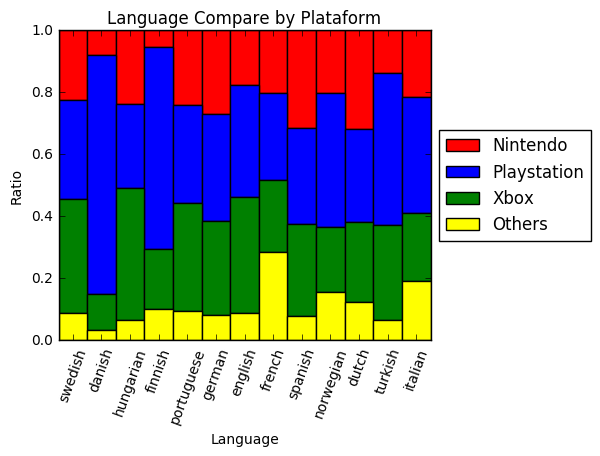

In [2]:
import matplotlib.pyplot as plt
import numpy as np


archivo = open("languages_amount_by_platform_summary.txt")

archivo.readline()
archivo.readline()
languages_nintendo = {}
languages_total = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	try:
		languages_total[line[2]] += int(line[3])
	except:
		languages_total[line[2]] = int(line[3])
	try:
		languages_nintendo[line[2]] += int(line[3])
	except:
		languages_nintendo[line[2]] = int(line[3])


archivo.readline()
archivo.readline()
languages_playstation = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	try:
		languages_total[line[2]] += int(line[3])
	except:
		languages_total[line[2]] = int(line[3])	
	try:
		languages_playstation[line[2]] += int(line[3])
	except:
		languages_playstation[line[2]] = int(line[3])


archivo.readline()
archivo.readline()
languages_xbox = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	try:
		languages_total[line[2]] += int(line[3])
	except:
		languages_total[line[2]] = int(line[3])	
	try:
		languages_xbox[line[2]] += int(line[3])
	except:
		languages_xbox[line[2]] = int(line[3])


archivo.readline()
archivo.readline()
languages_others = {}
chars_to_remove = [',', '[', ']', '"']
while True:
	i = archivo.readline()
	line = i.translate(None, ''.join(chars_to_remove))
	line = line.split()
	if len(line) == 0:
		break
	try:
		languages_total[line[2]] += int(line[3])
	except:
		languages_total[line[2]] = int(line[3])	
	try:
		languages_others[line[2]] += int(line[3])
	except:
		languages_others[line[2]] = int(line[3])

nintendo_count = []
playstation_count = []
xbox_count = []
others_count = []

for i in languages_total.keys():
	try:
		nintendo_count.append(languages_nintendo[i]/float(languages_total[i]))
	except:
		nintendo_count.append(0)
	try:
		playstation_count.append(languages_playstation[i]/float(languages_total[i]))
	except:
		playstation_count.append(0)
	try:
		xbox_count.append(languages_xbox[i]/float(languages_total[i]))
	except:
		xbox_count.append(0)
	try:
		others_count.append(languages_others[i]/float(languages_total[i]))
	except:
		others_count.append(0)



width= 1
x_valus=languages_total.keys()
ind=np.arange(len(x_valus))
ax = plt.subplot(111)
bottom=[1]*len(x_valus)
plt.xticks(ind + 0.5, x_valus, rotation=70)
bottom -= np.array(nintendo_count)
plt.bar(ind , nintendo_count, width,label='Nintendo', color='red', bottom=bottom)
bottom -= np.array(playstation_count)
plt.bar(ind, playstation_count, width,label='Playstation', bottom=bottom)
bottom -= np.array(xbox_count)
plt.bar(ind, xbox_count, width,label='Xbox', bottom=bottom, color='green')
bottom -= np.array(others_count)
plt.bar(ind, others_count, width,label='Others', bottom=bottom, color='yellow')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Language Compare by Plataform")
plt.xlabel('Language')
plt.ylabel('Ratio')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.show()


# Experiments

1) We believe that the users of the Playstation have a tendence in making tweets with more negative sentiment than the other platforms in percentage, because otherwise the size of the amount of tweets would make it the comparison more about size (amount of twees) than the content made itself.

2) At the same time we believe that the Nintendo platform is the one with the most positive sentiment tweets, compared to the other platforms in percentages.

Both of this experiments and more can be proven right or wrong with the next script. Of course after the results manual analysis must be made.


Nintendo



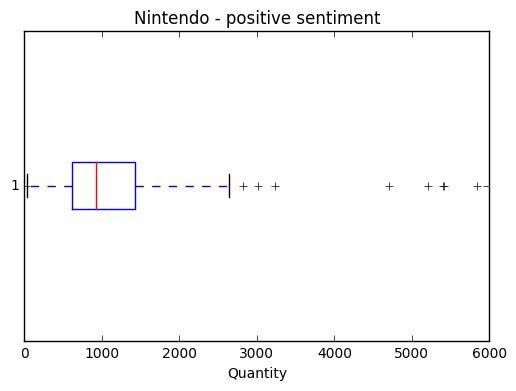

The next information is for tweets with positive sentiment. The average was: 1069.98730964. The standard deviation was: 752.251522782
The percentage of positive sentiment tweets in this platform was: 31.99%


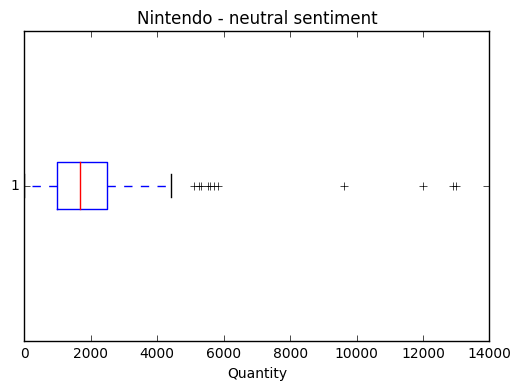

The next information is for tweets with neutral sentiment. The average was: 1877.92405063. The standard deviation was: 1460.07768874
The percentage of neutral sentiment tweets in this platform was: 56.29%


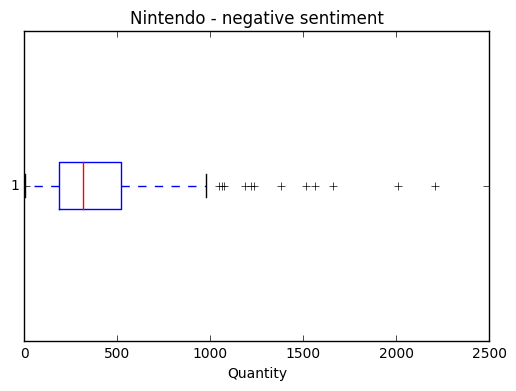

The next information is for tweets with negative sentiment. The average was: 390.663291139. The standard deviation was: 291.027996881
The percentage of negative sentiment tweets in this platform was: 11.71%

Playstation



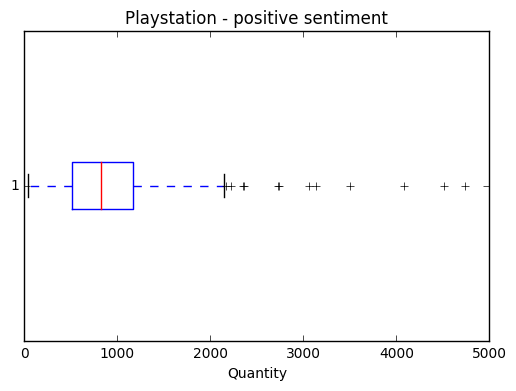

The next information is for tweets with positive sentiment. The average was: 926.086294416. The standard deviation was: 616.4917964
The percentage of positive sentiment tweets in this platform was: 15.61%


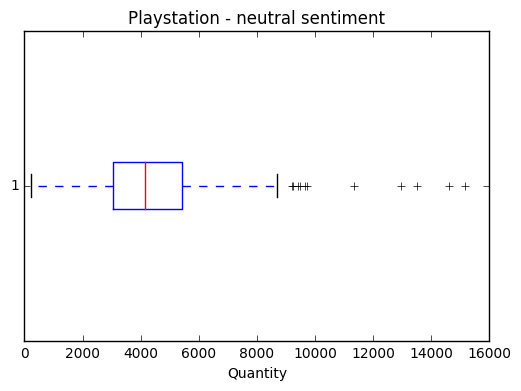

The next information is for tweets with neutral sentiment. The average was: 4324.84771574. The standard deviation was: 2093.1371678
The percentage of neutral sentiment tweets in this platform was: 72.89%


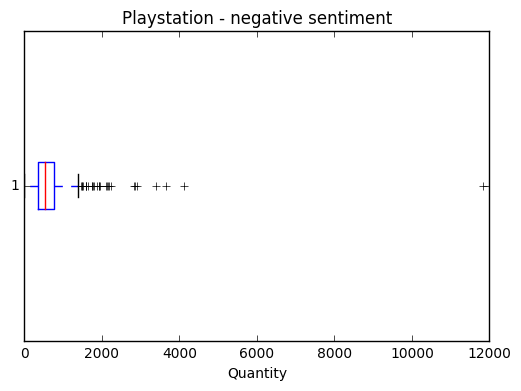

The next information is for tweets with negative sentiment. The average was: 681.04556962. The standard deviation was: 763.526903877
The percentage of negative sentiment tweets in this platform was: 11.51%

Xbox



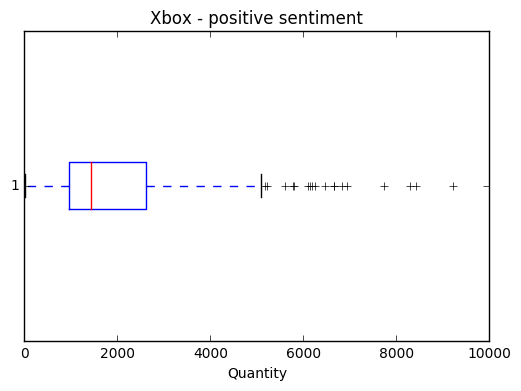

The next information is for tweets with positive sentiment. The average was: 1885.36040609. The standard deviation was: 1520.19631016
The percentage of positive sentiment tweets in this platform was: 32.87%


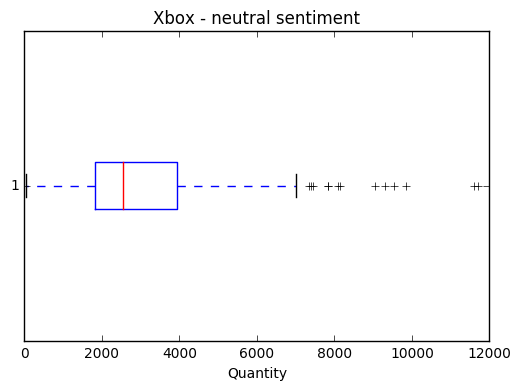

The next information is for tweets with neutral sentiment. The average was: 2879.20812183. The standard deviation was: 1901.86013734
The percentage of neutral sentiment tweets in this platform was: 50.19%


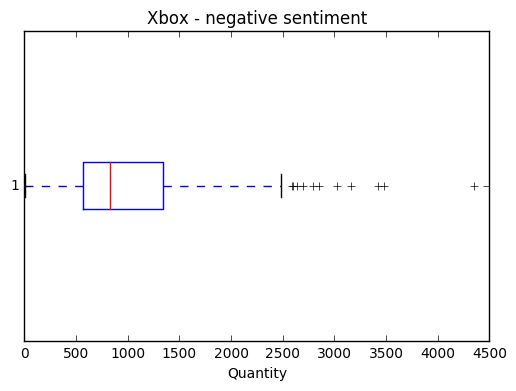

The next information is for tweets with negative sentiment. The average was: 971.870558376. The standard deviation was: 657.105443102
The percentage of negative sentiment tweets in this platform was: 16.94%

Else



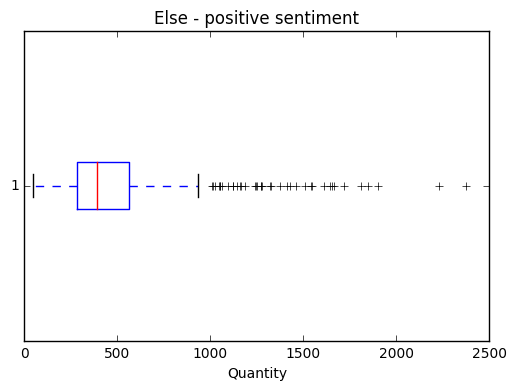

The next information is for tweets with positive sentiment. The average was: 499.256345178. The standard deviation was: 356.877592535
The percentage of positive sentiment tweets in this platform was: 26.75%


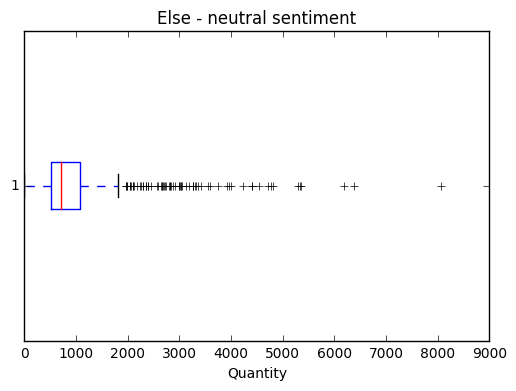

The next information is for tweets with neutral sentiment. The average was: 1119.27594937. The standard deviation was: 1122.17689427
The percentage of neutral sentiment tweets in this platform was: 60.12%


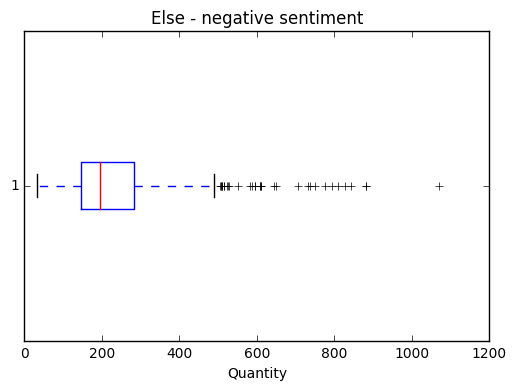

The next information is for tweets with negative sentiment. The average was: 245.149746193. The standard deviation was: 159.562300204
The percentage of negative sentiment tweets in this platform was: 13.13%


In [1]:
import matplotlib.pyplot as plt
import numpy as np

class Platform:
    def __init__(self, name):
        self.name = name
        self.sentiments = {}

    def add_sentiment_amount(self, sentiment_list, sentiment_key):
        self.sentiments[sentiment_key] = sentiment_list

    def add_total_tweets(self, total):
        self.total = float(total)

    def print_sentiments_statistics(self):
        print "\n{}\n".format(self.name)
        for sentiment_list in self.sentiments.items():
            average_sentiment = np.average(sentiment_list[1])
            std_deviation_sentiment= np.std(sentiment_list[1], ddof=1)
            plt.boxplot(sentiment_list[1], vert=False)
            plt.title("{} - {} sentiment".format(self.name, sentiment_list[0]))
            plt.xlabel('Quantity')
            plt.show()
            total_sentiment = 0
            for i in sentiment_list[1]:
                total_sentiment += i
            print "The next information is for tweets with {} sentiment. The average was: {}. The standard deviation was: {}".format(sentiment_list[0], average_sentiment, std_deviation_sentiment)
            print "The percentage of {} sentiment tweets in this platform was: {}%".format(sentiment_list[0], round(total_sentiment/self.total*100, 2))


archivo = open("sentiment_analysis_by_platform_summary.txt")
archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
    i = archivo.readline()
    line = i.translate(None, ''.join(chars_to_remove))
    line = line.split()
    if len(line) == 0:
        break
    if line[2] == "pos":
        pos.append([int(line[0]), int(line[1]), int(line[3])])
    elif line[2] == "neg":
        neg.append([int(line[0]), int(line[1]), int(line[3])])
    else:
        neu.append([int(line[0]), int(line[1]), int(line[3])])

# Statistics
nintendo = Platform("Nintendo")
negs_count = []
for row in neg:
    negs_count.append(row[2])
pos_count = []
for row in pos:
    pos_count.append(row[2])
neu_count = []
for row in neu:
    neu_count.append(row[2])

nintendo.add_sentiment_amount(negs_count, "negative")
nintendo.add_sentiment_amount(neu_count, "neutral")
nintendo.add_sentiment_amount(pos_count, "positive")
total = 0
for i in negs_count:
    total += i
for i in pos_count:
    total += i
for i in neu_count:
    total += i
nintendo.add_total_tweets(total)
nintendo.print_sentiments_statistics()

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
    i = archivo.readline()
    line = i.translate(None, ''.join(chars_to_remove))
    line = line.split()
    if len(line) == 0:
        break
    if line[2] == "pos":
        pos.append([int(line[0]), int(line[1]), int(line[3])])
    elif line[2] == "neg":
        neg.append([int(line[0]), int(line[1]), int(line[3])])
    else:
        neu.append([int(line[0]), int(line[1]), int(line[3])])

# Statistics
playstation = Platform("Playstation")
negs_count = []
for row in neg:
    negs_count.append(row[2])
pos_count = []
for row in pos:
    pos_count.append(row[2])
neu_count = []
for row in neu:
    neu_count.append(row[2])

playstation.add_sentiment_amount(negs_count, "negative")
playstation.add_sentiment_amount(neu_count, "neutral")
playstation.add_sentiment_amount(pos_count, "positive")
total = 0
for i in negs_count:
    total += i
for i in pos_count:
    total += i
for i in neu_count:
    total += i
playstation.add_total_tweets(total)
playstation.print_sentiments_statistics()

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
    i = archivo.readline()
    line = i.translate(None, ''.join(chars_to_remove))
    line = line.split()
    if len(line) == 0:
        break
    if line[2] == "pos":
        pos.append([int(line[0]), int(line[1]), int(line[3])])
    elif line[2] == "neg":
        neg.append([int(line[0]), int(line[1]), int(line[3])])
    else:
        neu.append([int(line[0]), int(line[1]), int(line[3])])

# Statistics
xbox = Platform("Xbox")
negs_count = []
for row in neg:
    negs_count.append(row[2])
pos_count = []
for row in pos:
    pos_count.append(row[2])
neu_count = []
for row in neu:
    neu_count.append(row[2])

xbox.add_sentiment_amount(negs_count, "negative")
xbox.add_sentiment_amount(neu_count, "neutral")
xbox.add_sentiment_amount(pos_count, "positive")
total = 0
for i in negs_count:
    total += i
for i in pos_count:
    total += i
for i in neu_count:
    total += i
xbox.add_total_tweets(total)
xbox.print_sentiments_statistics()

archivo.readline()
archivo.readline()
pos = []
neg = []
neu = []
chars_to_remove = [',', '[', ']', '"']
while True:
    i = archivo.readline()
    line = i.translate(None, ''.join(chars_to_remove))
    line = line.split()
    if len(line) == 0:
        break
    if line[2] == "pos":
        pos.append([int(line[0]), int(line[1]), int(line[3])])
    elif line[2] == "neg":
        neg.append([int(line[0]), int(line[1]), int(line[3])])
    else:
        neu.append([int(line[0]), int(line[1]), int(line[3])])

# Statistics
_else = Platform("Else")
negs_count = []
for row in neg:
    negs_count.append(row[2])
pos_count = []
for row in pos:
    pos_count.append(row[2])
neu_count = []
for row in neu:
    neu_count.append(row[2])

_else.add_sentiment_amount(negs_count, "negative")
_else.add_sentiment_amount(neu_count, "neutral")
_else.add_sentiment_amount(pos_count, "positive")
total = 0
for i in negs_count:
    total += i
for i in pos_count:
    total += i
for i in neu_count:
    total += i
_else.add_total_tweets(total)
_else.print_sentiments_statistics()


**Analysis**

From the results we can see the average, the standard deviation, the percentage of the data of that platform in one sentiment and a box-plot to further analysis.

1) It turns out that the percentage of all the tweets made about the platform Playstation. There is a 11.51% tweets with negative sentiment. While in Nintendo there is an 11.71%, in Xbox there is a 16.94% and in Else there is a 13.13%. Which means that the platform with most negative sentiment tweets against their own total is Xbox with a 16.94%. We thought Playstation would have more negative tweets overall just because there was an extreme peak of negative tweets in one of graphics we made earlier, this peak can be see in the boxplot of "Playstation - negative sentiment", but the boxplot also allow us to see that it was the most far away outlier and that almost 100% of the negative tweets per hour about Playstation does not go over 1.5k tweets, but this outlier was near 12k tweets. This fact can also be checked with the average amount of tweets per hour and the standard deviation, because the average + std. deviation would be 1.4k which is about were 100% of negative tweets per hour would be, which also means that 12k negative tweets is not normal at all.

2) It turns out that the percentage of all the tweets made about the platform Playstation. There is only a 31.99% tweets with positive sentiment. While in Playstation there is an 15.61%, in Xbox there is a 32.87% and in Else there is a 26.75%. Which means that the platform with most positive sentiment tweets against their own total is Xbox with a 32.87%. We thought Nintendo would have more positive tweets overall just because there were pretty stable or followed certain pattern in the graphic we show before, this stable tendece can be see in the boxplot of "Nintendo - positive sentiment", with the tiny amount of outliers that are really far of the boxplot. But with the boxplot "Xbox - positive sentiment", we can see that the boxplot of it is moved more to the right, in other words the quantity is about twice as Nintendo positive tweets in the average or 50% amount of the data. The fact that Xbox has more positive sentiment tweets can also be checked with the average amount of tweets per hour and the standard deviation, since the standard deviation of Xbox is just 152 while Nintendo has 752, is a very important reason to see which one is more "stable" in their positive-ness. And that the average of Xbox positive tweets per hour is more than Nintendo's, with less deviation only leaves one possibility for nintendo to "win" which would be the amount of data that those averages represent, because if the xbox was more stable but compared against the total was almost nothing then Nintendo would have "won" but that was not the case. 

# The End.